### Исследование временных рядов по данным о безрботице

In [26]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


#### Данные о заработной плате за каждый месяц с января 1993 по август 2016

In [27]:
data = pd.read_csv('WAG_C_M.csv',';', index_col = 'month', parse_dates = ['month'], dayfirst = True)

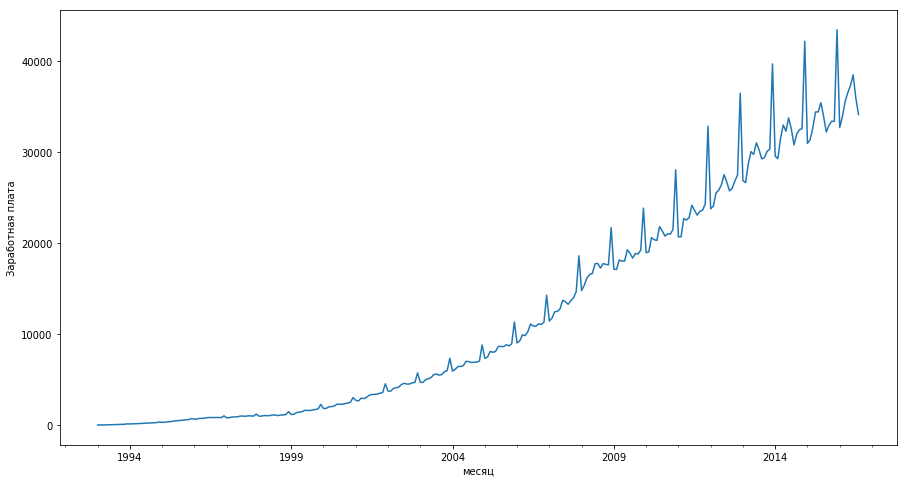

In [39]:
plt.figure(figsize(15,8))
data['WAG_C_M'].plot()
plt.ylabel(u'Заработная плата, руб')
plt.xlabel(u'месяц')
pylab.show()

### STL-декомпозиция ряда:

Проведем STL-декомпозицию ряда чтобы выделить основной тренд, сезонность и остатки.

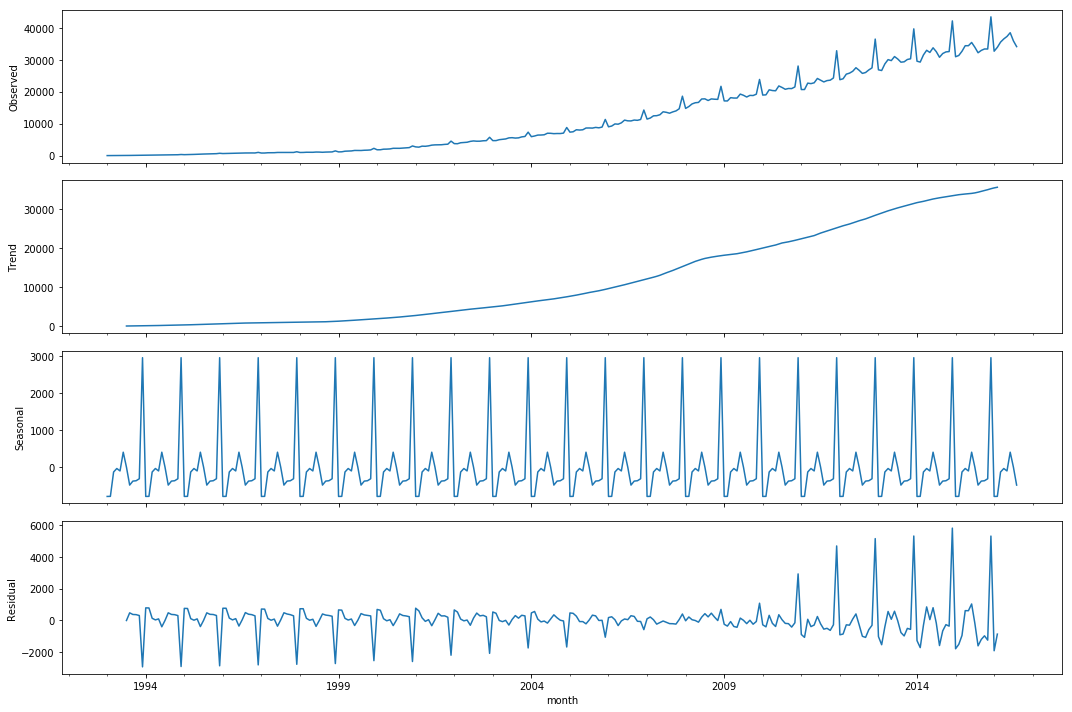

Критерий Дики-Фуллера: p=0.991850


In [45]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Наблюдается ярко выраженный тренд(постепеный рост). Также, ярко выраженна сезонность временного ряда. Дисперсия нестационарна, со временем разброс значений становится все больше.

### Стабилизация дисперсии методом Бокса-Кокса

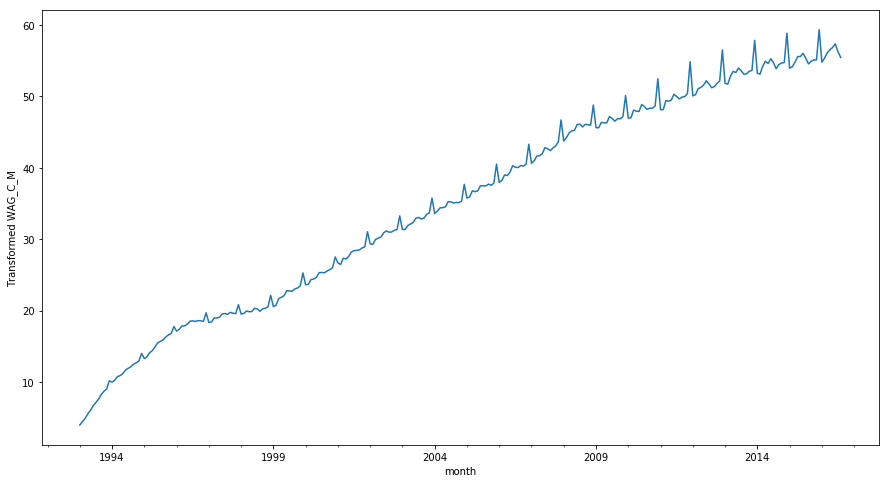

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


In [49]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,8))
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed WAG_C_M')
plt.show()
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Чтобы добиться стационарности ряда, проведем сезонное дифференцирование, а также STL-декомпозицию ряда: 

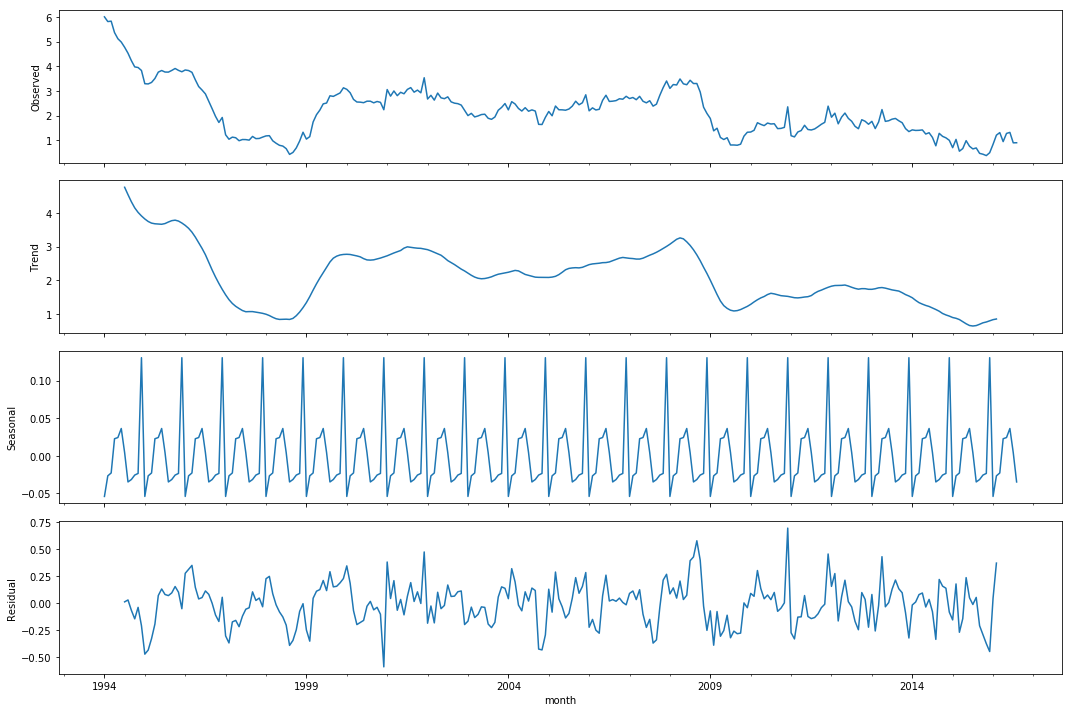

In [52]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
plt.show()

In [56]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1]

Критерий Дики-Фуллера: p=0.014697


Критерий Дики-Фуллера не отвегает гипотезу о нестационарности ряда. Действительно, посмотрев на трендовую компоненту, в среднем интервале она близка к константному значению. Поэтому применим еще одно дифференцирование - обычное.

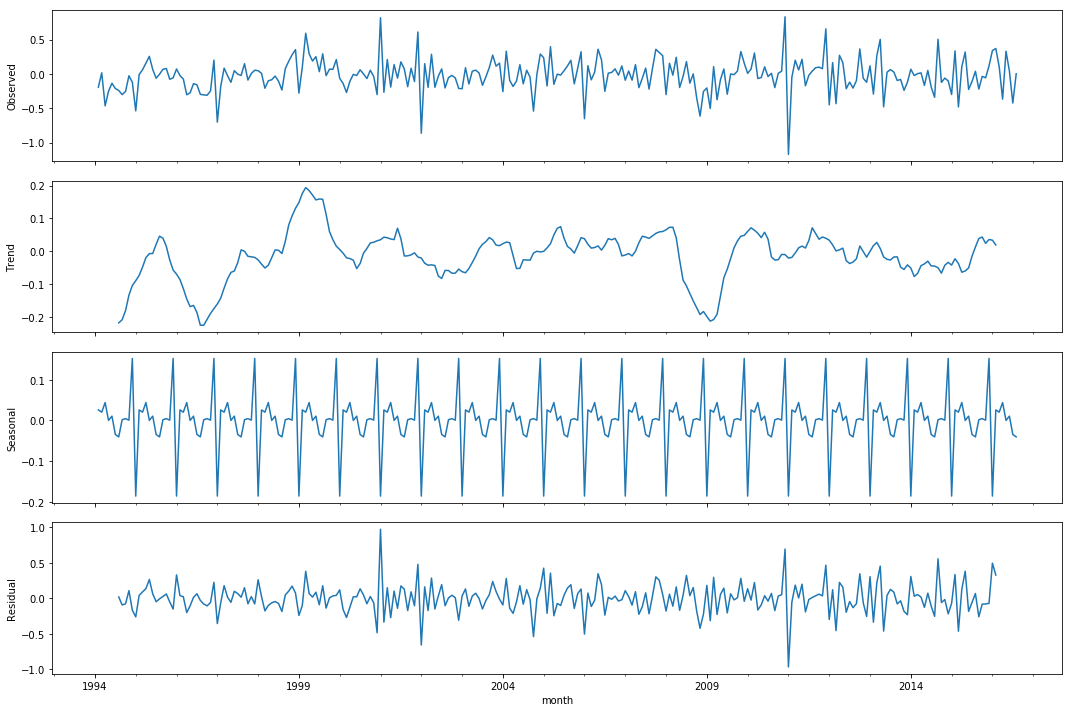

In [57]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()
plt.show()

Видим, что в трендовой компоненте ряда не наблюдается никакого систематического поведения, она колеблется вокруг константы. Видимо этот ряд уже можно считать стационарным.

In [58]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1]

Критерий Дики-Фуллера: p=0.000000


Согласно критерию Дики-Фуллера гипотеза о нестационарности ряда отвергается.

### Подбор модели ARIMA

Посмотрим на ACF(автокорреляционную функцию) и PACF(частично автокорреляционную функцию) полученного ряда для того чтобы подобрать начальные приближения параметров p,q, P, Q

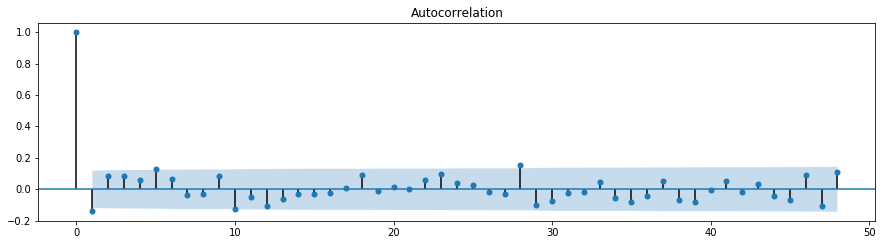

In [105]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()


По графику автокоррелиции видно, что сезонных лагов со значимой корреляцией нет, значит, начальное приближение Q = 0. Номер последнего несезонного лага, при котором автокорреляция значима q = 1.

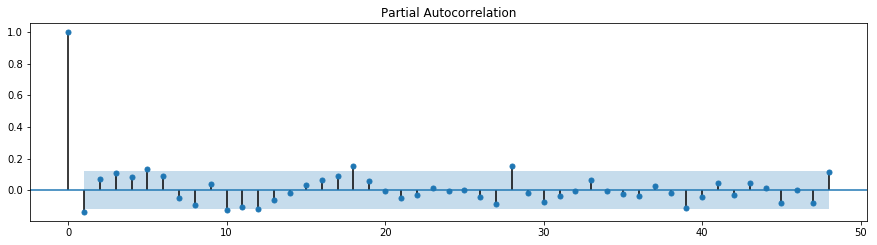

In [106]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q = 0, q = 1, P = 3, p = 1

In [107]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [108]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [109]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print "Всего комбинаций параметров:", len(parameters_list)

Всего комбинаций параметров: 16


In [110]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
CPU times: user 13.5 s, sys: 454 ms, total: 14 s
Wall time: 7.2 s


In [111]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
8   (1, 0, 1, 0)  0.340521
4   (0, 1, 1, 0)  1.170768
9   (1, 0, 2, 0)  1.622924
12  (1, 1, 1, 0)  2.021911
5   (0, 1, 2, 0)  2.509650


Лучшая модель:

In [112]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sun, 07 Oct 2018   AIC                              0.341
Time:                                    03:28:06   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


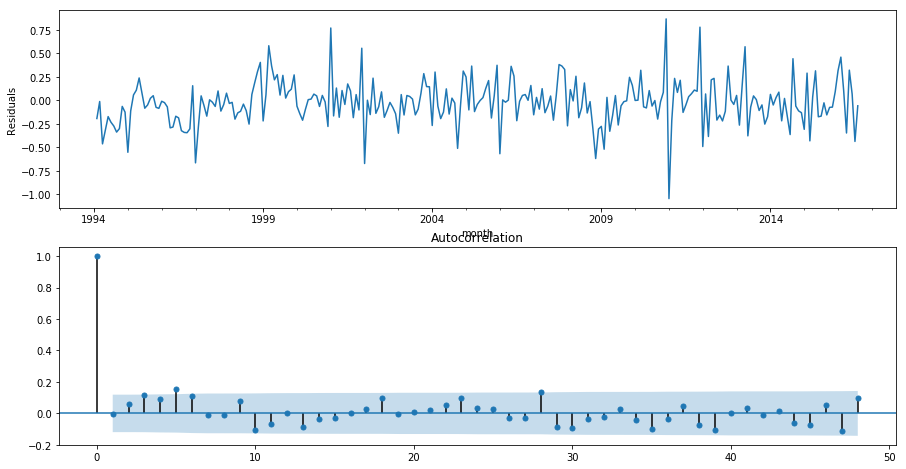

In [113]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [114]:
# определим обратное преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

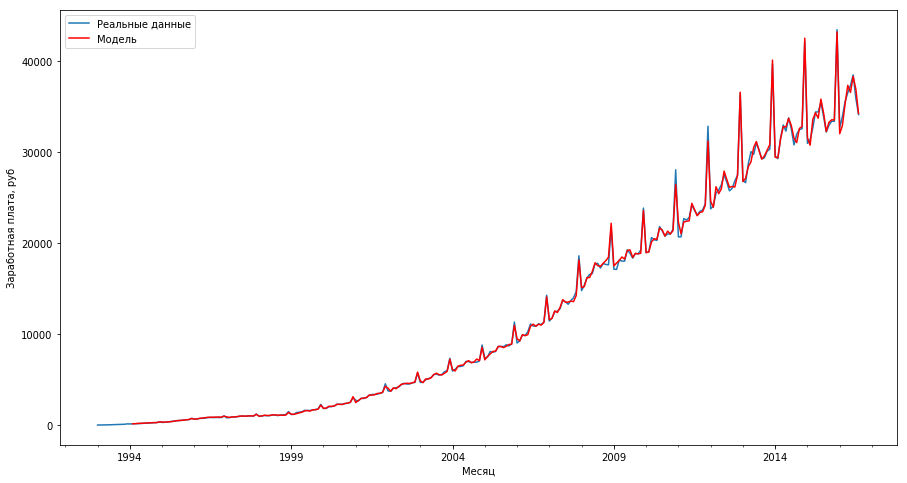

In [115]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,8))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel(u'Заработная плата, руб')
plt.xlabel(u'Месяц')
plt.legend( [u'Реальные данные', u'Модель'])
pylab.show()

### Прогноз заработной платы на следующие 2 года:

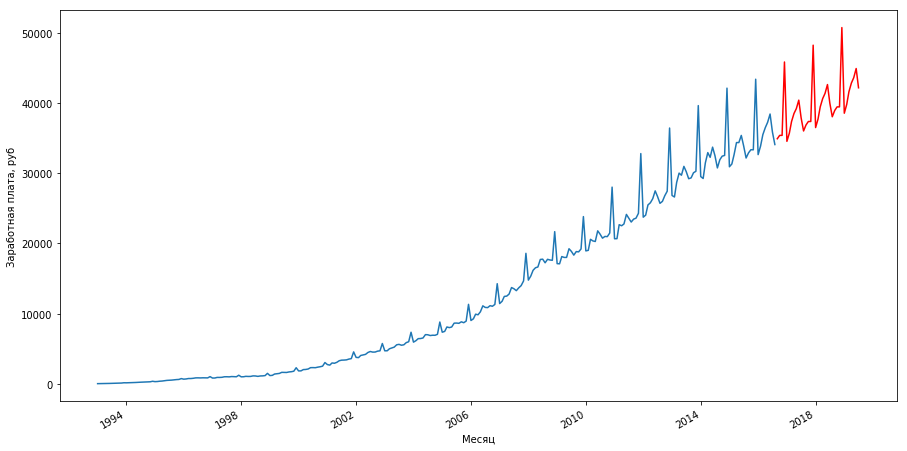

In [119]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,8))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel(u'Заработная плата, руб')
plt.xlabel(u'Месяц')
pylab.show()
